In [ ]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sklearn
import sklearn.datasets

from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

![gradientnyi-busting-e1543335419162.jpg](attachment:gradientnyi-busting-e1543335419162.jpg)

[link text](https://)![68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313630302f312a70775049472d475748796150564d564747354f6841512e676966.gif](attachment:68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313630302f312a70775049472d475748796150564d564747354f6841512e676966.gif)

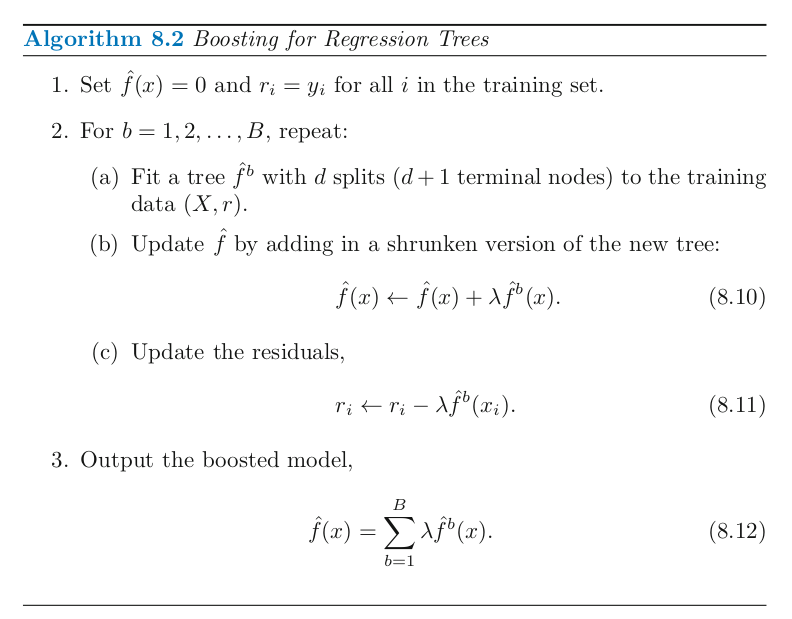

$$L_{MSE} = \frac{1}{2}(y - f(x))^2$$
$$e_m(x) = - \frac{dL}{f} = y - f(x)$$

* Применение дерева решений на данных
* Вычисление погрешности ошибок. Фактическое целевое значение, минус прогнозируемое целевое значение $e_1 = y — y\_pred_1$
* Установка новой модели для отклонений в качестве целевой переменной с одинаковыми входными переменными $e_1\_pred$
* Добавление предсказанных отклонений к предыдущим прогнозам $y\_pred_2 = y\_pred_1 + e_1\_pred$
* Установка еще одной модели оставшихся отклонений $e_2 = y — y\_pred_2$

![1.png](attachment:1.png)

![2.png](attachment:2.png)

![3.png](attachment:3.png)

![5.png](attachment:5.png)

# Практические замечания по градиентному бустингу

### sklearn

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_hastie_10_2

n_estimators = 200

X, y = make_hastie_10_2(n_samples=10000)
X_test, y_test = make_hastie_10_2(n_samples=10000)
est = GradientBoostingClassifier(n_estimators=200, max_depth=3)
est.fit(X, y)

pred = est.predict(X)
est.predict_proba(X)[0]  

array([0.03902751, 0.96097249])

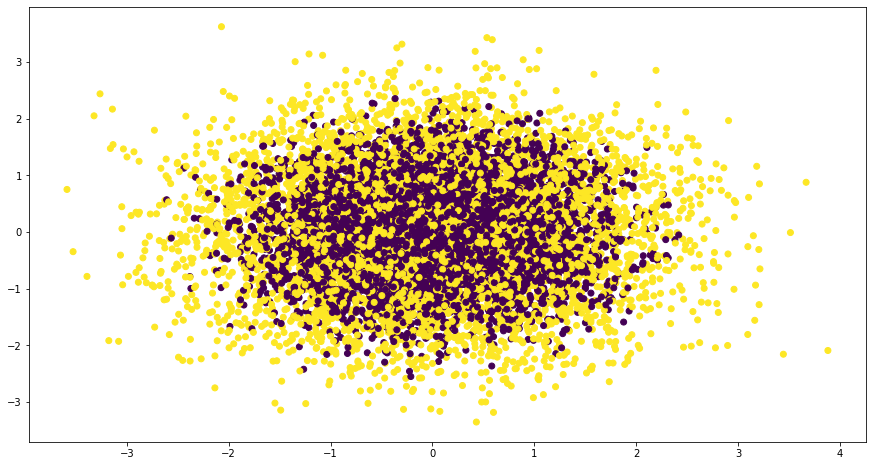

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y)

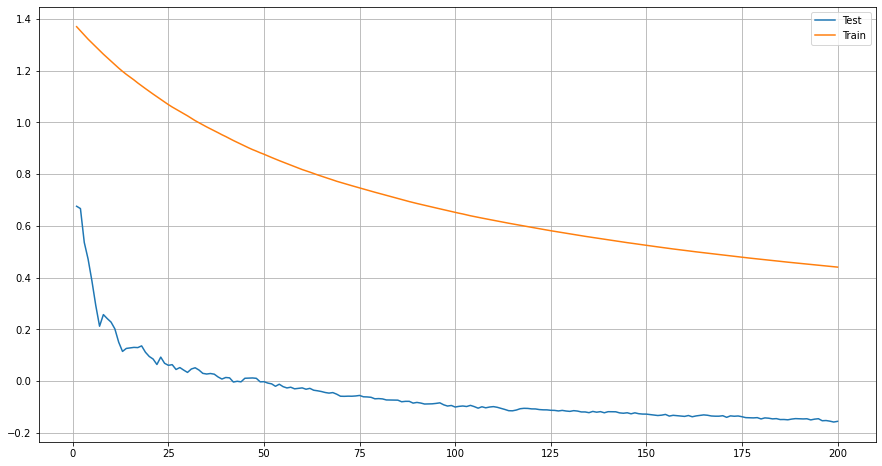

In [ ]:
test_score = np.empty(len(est.estimators_))
for i, pred in enumerate(est.staged_predict(X_test)):
    test_score[i] = est.loss_(y_test, pred)
plt.plot(np.arange(n_estimators) + 1, test_score, label='Test')
plt.plot(np.arange(n_estimators) + 1, est.train_score_, label='Train')
plt.legend(loc = 'best')
plt.grid()

![6.png](attachment:6.png)

![7.png](attachment:7.png)

![8.png](attachment:8.png)

# Подбор параметров бустинга
- параметры бустинга (количество базовых алгоритмов, )
- параметры базового алгоритма (например, для решающих деревьев: глубина, критерий)
- параметры задачи (функция потерь, размер выборки, признаки)

booster [default=gbtree] - тип базового алгоритма для бустинга: дерево решений gbtree или линейная модель gblinear.  
nthread [default to maximum number of threads available if not set] - число потоков доступных для параллельной работы xgboost.

eta [default=0.3] - темп обучения, перед добавлением дерева в композицию оно умножается на eta. Используется для предотвращения переобучения за счёт "сокращения" весов базовых алгоритмов, делая модель более консервативной. Чем меньше eta, тем больше нужно итераций num_boost_round для обучения модели с хорошим качеством. Диапазон: [0, 1]  
gamma [default=0] - минимальное снижение значения функции потерь, необходимое для дальнейшего разбиения вершины дерева. Большие значения gamma > 0 приводят к более консервативным моделям. Диапазон: [0, $\infty$).  
max_depth [default=6] - максимальная глубина дерева. Диапазон: [1, $\infty$).  
subsample [default=1] - доля выборки, используемая для обучения каждого дерева. Если subsample < 1, то выбирается случайная подвыборка, что помогает в борьбе с переобучением. Диапазон: (0, 1]  
colsample_bytree [default=1] - доля признаков, используемая для обучения каждого дерева. Диапазон: (0, 1]  
lambda [default=1] - коэффициент перед $L_2$-регуляризатором в функции потерь.  
alpha [default=0] - коэффициент перед $L_1$-регуляризатором в функции потерь.  


objective [default=reg:linear] - используемая при обучении функция потерь  


Более подробная информация о параметрах XGBoost-a в https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
import time
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification

xgb_params1 = {'booster': 'gbtree', 'max_depth': 3, 'eta': 0.1, 
     'objective': 'binary:logistic', 'nthread': 1, 'eval_metric' : "error",}
xgb_params2 = {'booster': 'gbtree', 'max_depth': 3, 'eta': 0.1, 
     'objective': 'binary:logistic', 'nthread': 4, 'eval_metric' : "error",}
sklearn_params = {'n_estimators': 100, 'max_depth': 3}

xgb_time1 = list()
xgb_time2 = list()
sklearn_time = list()

n_runs = 50

for i in range(n_runs):
    X, y = make_classification(n_samples=1000, n_features=50, 
                               n_informative=20)
    t = time.time()
    bst = xgb.train(xgb_params1, xgb.DMatrix(X, label=y), 
                    num_boost_round=100)
    elapsed = time.time() - t
    xgb_time1.append(elapsed)
    t = time.time()
    bst = xgb.train(xgb_params2, xgb.DMatrix(X, label=y), 
                    num_boost_round=100)
    elapsed = time.time() - t
    xgb_time2.append(elapsed)
    t = time.time()
    clf = GradientBoostingClassifier(**sklearn_params).fit(X, y)
    elapsed = time.time() - t
    sklearn_time.append(elapsed)

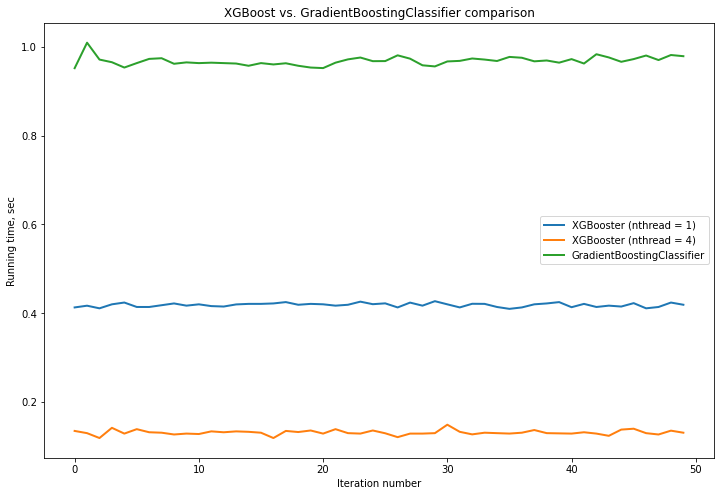

In [ ]:
%matplotlib  inline
import matplotlib.pyplot as plt

xgb_mean1 = sum(xgb_time1) / n_runs
xgb_mean2 = sum(xgb_time2) / n_runs
sklearn_mean = sum(sklearn_time) / n_runs

plt.figure(figsize=(12, 8))
plt.plot(xgb_time1, label='XGBooster (nthread = 1)', lw=2)
plt.plot(xgb_time2, label='XGBooster (nthread = 4)', lw=2)
plt.plot(sklearn_time, label='GradientBoostingClassifier', lw=2)
plt.legend(loc='best')
plt.xlabel('Iteration number')
plt.ylabel('Running time, sec')
plt.title('XGBoost vs. GradientBoostingClassifier comparison')
plt.show()

## Bias Variance tradeoff

In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=8, 
                           n_redundant=3, n_repeated=2, random_state=42)

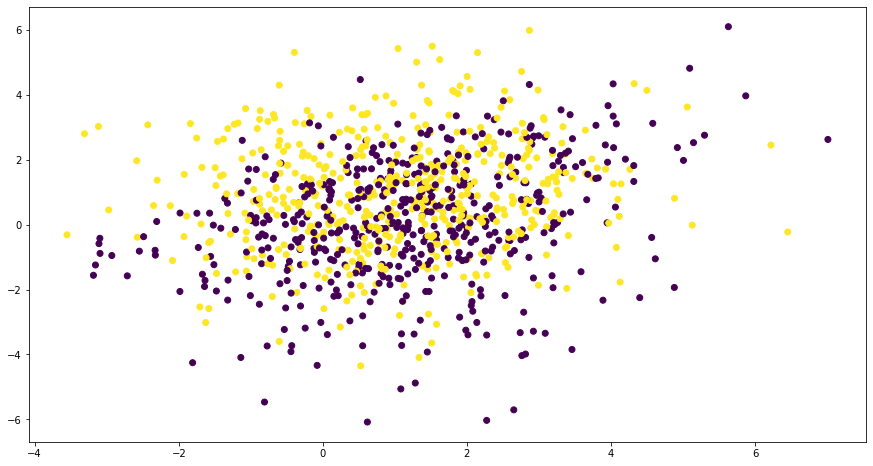

In [ ]:
plt.scatter(X[:, 2], X[:, 1], c=y)

In [ ]:
from collections import Counter
Counter(y)

Counter({0: 497, 1: 503})

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
    'silent': 1.0,
    'seed': 42
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv.split(X, y),
    scoring='accuracy',
    n_jobs=-1
)

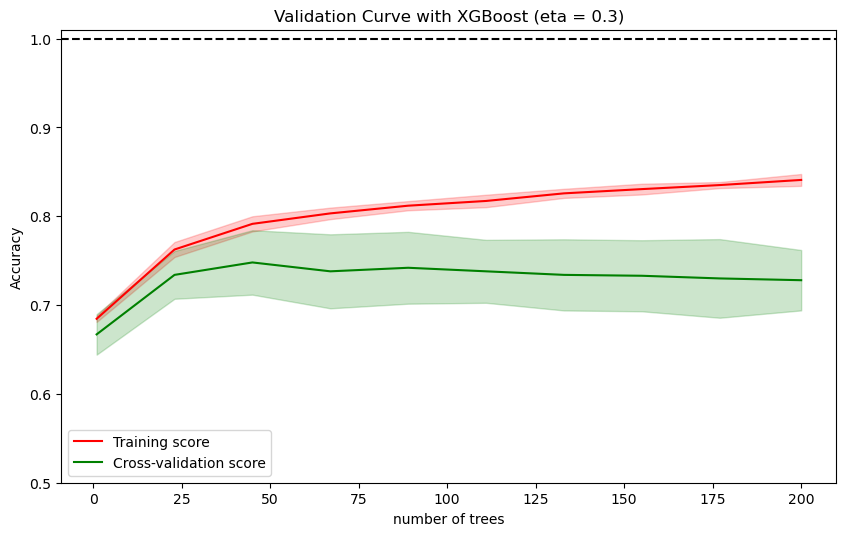

Best cross-validation result (0.75) obtained for 45 trees


In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.01)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))